In [ ]:
!pip install plot_utils

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Dense, Conv2DTranspose, Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Dropout, BatchNormalization, LeakyReLU
import numpy as np
import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
%matplotlib inline

In [ ]:
#loading fashion mnist data from keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
#using the tensorflow.data.Dataset API to make the training dataset
#we shuffle with buffer size 1000
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [ ]:
num_features = 100 #number of dimensions of the input latent variable space(noise)

#Generator
generator = Sequential()
generator.add(Dense(7*7*128, input_shape=(num_features,)))
generator.add(Reshape([7, 7, 128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', activation='selu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', activation='tanh'))

In [ ]:
#discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, (5,5), strides = (2,2), padding='same', input_shape=(28,28,1,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False

#combining the generator and the discriminator
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [ ]:
seed = tf.random.normal(shape=(batch_size, num_features))

In [ ]:
def train_dcgan(gan, dataset, batch_size, num_features, epochs=5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epochs {}/{}".format(epoch+1, epochs))
        for x_batch in dataset:
            noise = tf.random.normal(shape=(batch_size, num_features))
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0) #input for discriminator
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) #output for discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary') #rescaling the pixel values back to 0-255 range
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
x_train_dc_gan = x_train.reshape(-1, 28, 28, 1) * 2 - 1

In [ ]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dc_gan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

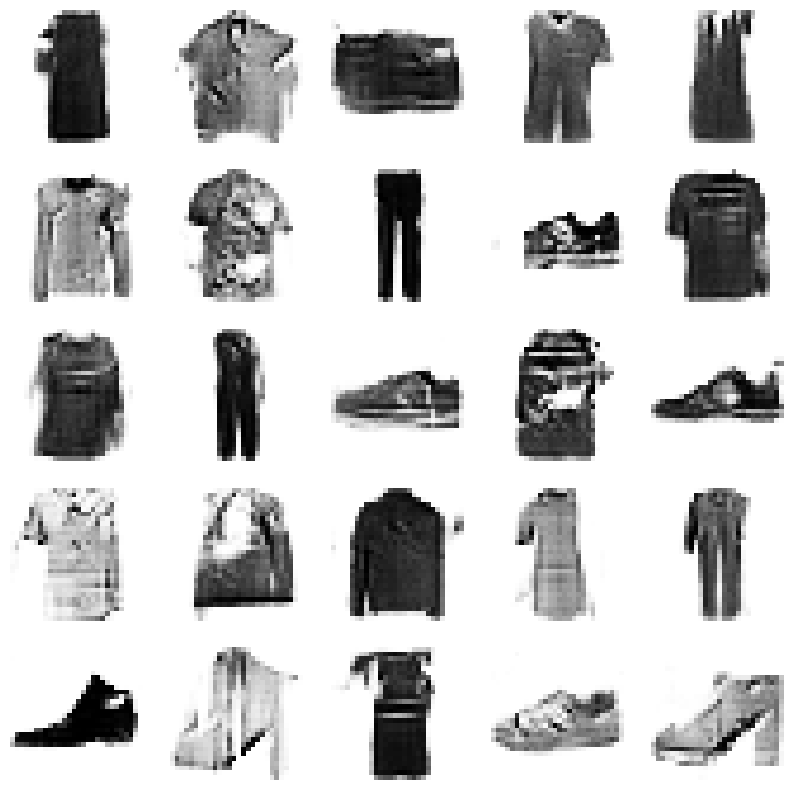

CPU times: user 9min 47s, sys: 22.6 s, total: 10min 10s
Wall time: 10min 31s


In [ ]:
%%time
train_dcgan(gan, dataset, batch_size, num_features, epochs=10)